# **Import Library**

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
seed = 0
np.random.seed(seed)
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
!pip install sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from wordcloud import WordCloud
import csv
import requests
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score, precision_score
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
!pip freeze > requirements.txt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# **Mengambil Data Hasil Scraping**

In [2]:
#membaca data yang sudah diambil
df=pd.read_csv('ulasan_apk.csv')

# **Preprocessing Data**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              20000 non-null  object
 1   userName              20000 non-null  object
 2   userImage             20000 non-null  object
 3   content               20000 non-null  object
 4   score                 20000 non-null  int64 
 5   thumbsUpCount         20000 non-null  int64 
 6   reviewCreatedVersion  18177 non-null  object
 7   at                    20000 non-null  object
 8   replyContent          9396 non-null   object
 9   repliedAt             9396 non-null   object
 10  appVersion            18177 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.7+ MB


In [4]:
df.isnull().sum()

,0
reviewId,0
userName,0
userImage,0
content,0
score,0
thumbsUpCount,0
reviewCreatedVersion,1823
at,0
replyContent,10604
repliedAt,10604


In [5]:
#membuang kolom yang kurang tidak diperlukan
df=df.drop(columns=['reviewCreatedVersion', 'replyContent', 'repliedAt', 'appVersion'])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   reviewId       20000 non-null  object
 1   userName       20000 non-null  object
 2   userImage      20000 non-null  object
 3   content        20000 non-null  object
 4   score          20000 non-null  int64 
 5   thumbsUpCount  20000 non-null  int64 
 6   at             20000 non-null  object
dtypes: int64(2), object(5)
memory usage: 1.1+ MB


In [7]:
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,at
0,31418d00-cebe-4996-a279-9a5cfb2e9e61,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Asli berguna juga programnya dan internalnya l...,5,2,2025-10-14 15:31:39
1,868e54f7-05fb-4f9a-896c-0a8ab6cd95cd,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Asli simpel juga, programnya dan interlnya leb...",5,1,2025-10-14 16:03:40
2,0f632e94-c28f-46c9-aa54-15597e4b3f91,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Asli oke juga, program & internalnya lebih fle...",5,1,2025-10-15 16:54:22
3,77e863c8-9ac0-42de-8be2-489024a30451,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Asli berguna banget! programnya dan internalny...,5,1,2025-10-15 17:37:00
4,017e2f67-8d00-4739-9373-b195bbdc2f86,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Asli praktis sekali! Programnya dan internalny...,5,0,2025-10-15 22:39:31


In [8]:
#menghapus data kosong dan data duplikat
df=df.dropna()
df=df.drop_duplicates()

In [9]:
#memastikan jumlah kolom dan bari dari data yang kita pakai
jumlah_ulasan_setelah_hapus_duplikat, jumlah_kolom_setelah_hapus_duplikat = df.shape
df.shape

(20000, 7)

**Preprocesing**

In [10]:
kata_slang = pd.read_excel('slang_word.xlsx')
kamus_slang = dict(zip(kata_slang['kata1'], kata_slang['kata2']))
def ganti_slang(teks):
    return ' '.join([kamus_slang.get(kata, kata) for kata in teks.split()])

def cleaning_teks(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r'RT[\s]', '', text)
    text = re.sub(r"http\S+", '', text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.replace('\n', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip(' ')
    return text

def casefolding_teks(text):
    text = text.lower()
    return text

def tokenizing_teks(text):
    text = word_tokenize(text)
    return text

def filtering_teks(text):
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemming_teks(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    stemmed_text = ' '.join(stemmed_words)
    return stemmed_text
    return stemmed_text

def sentence_teks(list_kata):
    sentence = ' '.join(word for word in list_kata)
    return sentence

In [11]:
df['text_clean'] = df['content'].apply(cleaning_teks)
df['text_casefolding_teks'] = df['text_clean'].apply(casefolding_teks)
df['text_normalized'] = df['text_casefolding_teks'].apply(ganti_slang)
df['text_tokenizing_teks'] = df['text_normalized'].apply(tokenizing_teks)
df['text_stopword'] = df['text_tokenizing_teks'].apply(filtering_teks)
df['text_akhir'] = df['text_stopword'].apply(sentence_teks)

In [12]:
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,at,text_clean,text_casefolding_teks,text_normalized,text_tokenizing_teks,text_stopword,text_akhir
0,31418d00-cebe-4996-a279-9a5cfb2e9e61,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Asli berguna juga programnya dan internalnya l...,5,2,2025-10-14 15:31:39,Asli berguna juga programnya dan internalnya l...,asli berguna juga programnya dan internalnya l...,asli berguna juga programnya dan internalnya l...,"[asli, berguna, juga, programnya, dan, interna...","[asli, berguna, programnya, internalnya, memad...",asli berguna programnya internalnya memadai di...
1,868e54f7-05fb-4f9a-896c-0a8ab6cd95cd,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Asli simpel juga, programnya dan interlnya leb...",5,1,2025-10-14 16:03:40,Asli simpel juga programnya dan interlnya lebi...,asli simpel juga programnya dan interlnya lebi...,asli simpel juga programnya dan interlnya lebi...,"[asli, simpel, juga, programnya, dan, interlny...","[asli, simpel, programnya, interlnya, tertata,...",asli simpel programnya interlnya tertata digun...
2,0f632e94-c28f-46c9-aa54-15597e4b3f91,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Asli oke juga, program & internalnya lebih fle...",5,1,2025-10-15 16:54:22,Asli oke juga program internalnya lebih fleks...,asli oke juga program internalnya lebih fleks...,asli oke juga program internalnya lebih fleksi...,"[asli, oke, juga, program, internalnya, lebih,...","[asli, oke, program, internalnya, fleksibel, p...",asli oke program internalnya fleksibel pakaibe...
3,77e863c8-9ac0-42de-8be2-489024a30451,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Asli berguna banget! programnya dan internalny...,5,1,2025-10-15 17:37:00,Asli berguna banget programnya dan internalnya...,asli berguna banget programnya dan internalnya...,asli berguna banget programnya dan internalnya...,"[asli, berguna, banget, programnya, dan, inter...","[asli, berguna, banget, programnya, internalny...",asli berguna banget programnya internalnya mem...
4,017e2f67-8d00-4739-9373-b195bbdc2f86,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Asli praktis sekali! Programnya dan internalny...,5,0,2025-10-15 22:39:31,Asli praktis sekali Programnya dan internalnya...,asli praktis sekali programnya dan internalnya...,asli praktis sekali programnya dan internalnya...,"[asli, praktis, sekali, programnya, dan, inter...","[asli, praktis, programnya, internalnya, memad...",asli praktis programnya internalnya memadai di...


**Pelabelan**

In [13]:
lexicon_positive = dict()
respon = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
if respon.status_code == 200:
    reader = csv.reader(StringIO(respon.text), delimiter=',')
    for row in reader:
        lexicon_positive[row[0]] = int(row[1])
else:
    print("Failed to fetch positive lexicon data")
lexicon_negative = dict()
respon = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
if respon.status_code == 200:
    reader = csv.reader(StringIO(respon.text), delimiter=',')
    for row in reader:
        lexicon_negative[row[0]] = int(row[1])
else:
    print("Failed to fetch negative lexicon data")

In [14]:
def sentiment_analysis_lexicon_indonesia(text):
    score = 0
    for kata in text:
        if (kata in lexicon_positive):
            score = score + lexicon_positive[kata]
    for kata in text:
        if (kata in lexicon_negative):
            score = score + lexicon_negative[kata]
    polarity=''
    if (score >= 0):
        polarity = 'positive'
    elif (score < 0):
        polarity = 'negative'
    else:
        polarity = 'neutral'
    return score, polarity

In [15]:
hasil = df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
hasil = list(zip(*hasil))
df['polarity_score'] = hasil[0]
df['polarity'] = hasil[1]
print(df['polarity'].value_counts())

polarity
positive    14404
negative     5596
Name: count, dtype: int64


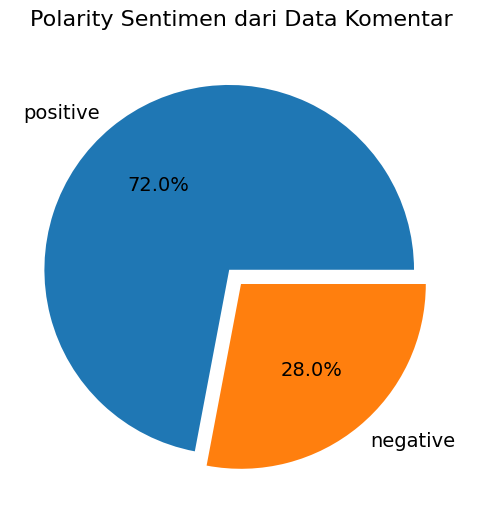

In [35]:
fig, ax = plt.subplots(figsize=(6, 6))
sizes = [count for count in df['polarity'].value_counts()]
labels = list(df['polarity'].value_counts().index)
explode = (0.1, 0)
ax.pie(x=sizes, labels=labels, autopct='%1.1f%%', explode=explode, textprops={'fontsize': 14})
ax.set_title('Polarity Sentimen dari Data Komentar', fontsize=16, pad=20)
plt.show()

In [17]:
pd.set_option('display.max_colwidth', 3000)
komentar_positif = df[df['polarity'] == 'positive']
komentar_positif = komentar_positif[['text_akhir', 'polarity_score', 'polarity','text_stopword']]
komentar_positif = komentar_positif.sort_values(by='polarity_score', ascending=False)
komentar_positif = komentar_positif.reset_index(drop=True)
komentar_positif.index += 1

In [18]:
pd.set_option('display.max_colwidth', 3000)
komentar_negatif = df[df['polarity'] == 'negative']
komentar_negatif = komentar_negatif[['text_akhir', 'polarity_score', 'polarity','text_stopword']]
komentar_negatif = komentar_negatif.sort_values(by='polarity_score', ascending=True)
komentar_negatif = komentar_negatif[0:10]
komentar_negatif = komentar_negatif.reset_index(drop=True)
komentar_negatif.index += 1

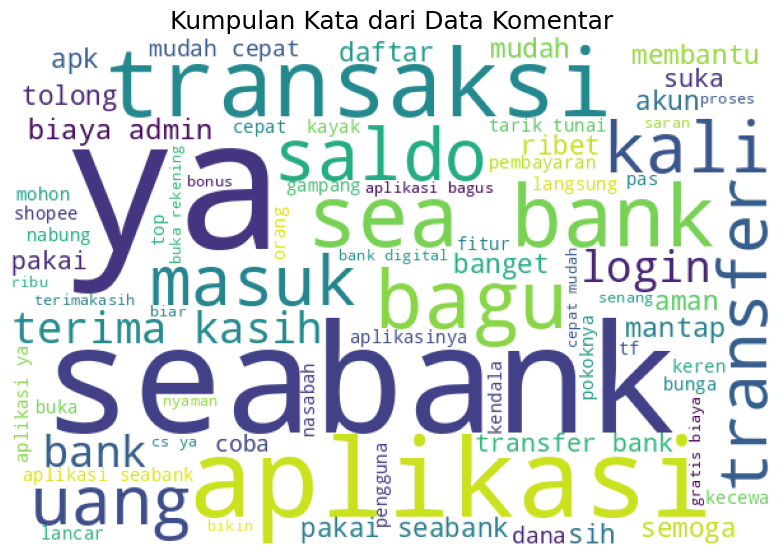

In [19]:
list_kata = ''
for komentar in df['text_stopword']:
    for kata in komentar:
        list_kata += ' ' + (kata)
kumpulan_kata = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_kata)
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Kumpulan Kata dari Data Komentar', fontsize=18)
ax.grid(False)
ax.imshow((kumpulan_kata))
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()

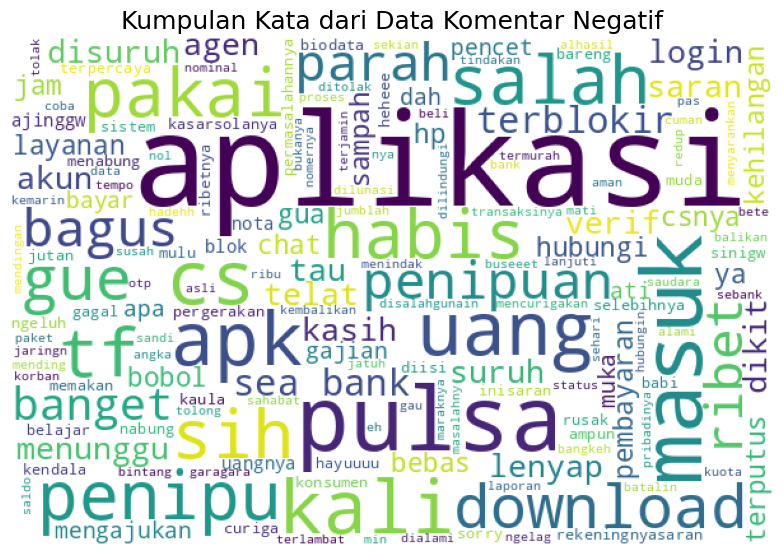

In [20]:
list_kata = ''
for komentar in komentar_negatif['text_stopword']:
    for kata in komentar:
        list_kata += ' ' + (kata)
kumpulan_kata = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_kata)
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Kumpulan Kata dari Data Komentar Negatif', fontsize=18)
ax.grid(False)
ax.imshow((kumpulan_kata))
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()

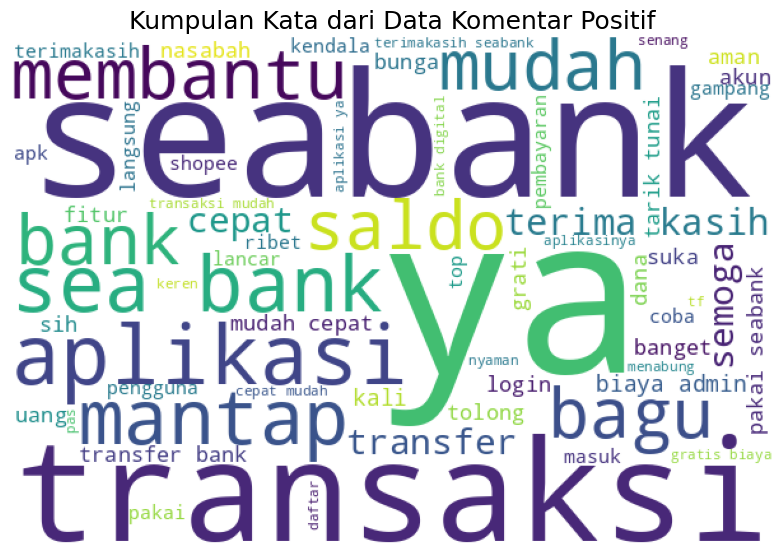

In [21]:
list_kata = ''
for komentar in komentar_positif['text_stopword']:
    for kata in komentar:
        list_kata += ' ' + (kata)
kumpulan_kata = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_kata)
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Kumpulan Kata dari Data Komentar Positif', fontsize=18)
ax.grid(False)
ax.imshow((kumpulan_kata))
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()

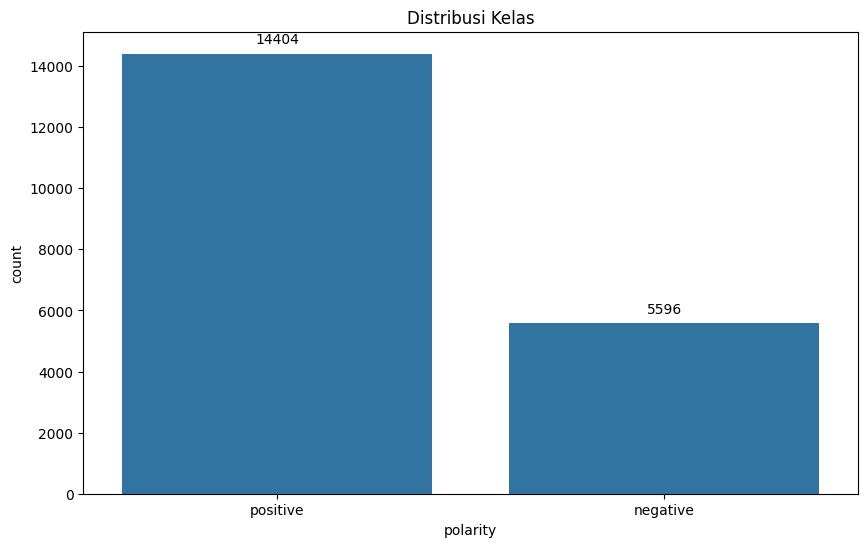

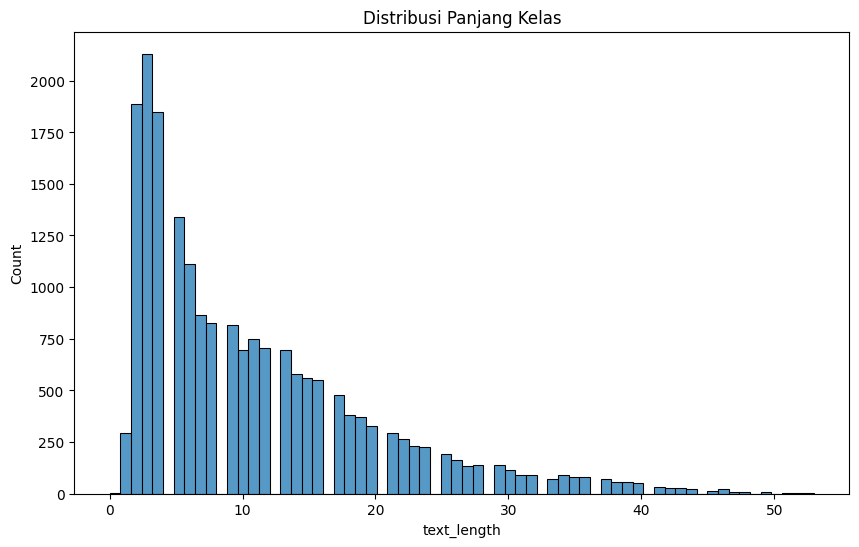

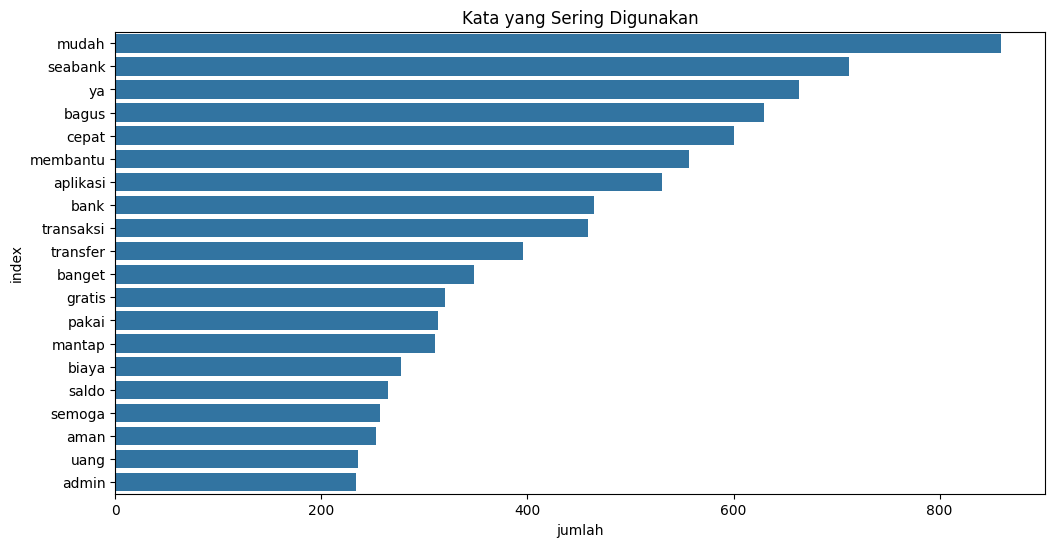

In [37]:
plt.figure(figsize=(10, 6))

grafik_distribusi_kelas = sns.countplot(x='polarity', data=df)
plt.title('Distribusi Kelas')

for p in grafik_distribusi_kelas.patches:
    grafik_distribusi_kelas.annotate(format(p.get_height(), '.0f'),
                              (p.get_x() + p.get_width() / 2., p.get_height()),
                              ha='center', va='center',
                              xytext=(0, 10),
                              textcoords='offset points')

plt.show()

plt.figure(figsize=(10, 6))

df['text_length'] = df['text_akhir'].apply(lambda x: len(x.split()))
sns.histplot(df['text_length'])
plt.title('Distribusi Panjang Kelas')
plt.show()

plt.figure(figsize=(12, 6))

vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000, min_df=5, max_df=0.9 )
X = vectorizer.fit_transform(df['text_akhir'])
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df = tfidf_df.sum().reset_index(name='jumlah')
tfidf_df = tfidf_df.sort_values('jumlah', ascending=False).head(20)
sns.barplot(x='jumlah', y='index', data=tfidf_df)
plt.title('Kata yang Sering Digunakan')
plt.show()

## **Lagoritma Machine Learning Metode Random Fores dengan Pembagian Data Latih 80% dan Data Uji 20% dengan Menerapkan TF-IDF dan SMOTE**

In [23]:
# SMOTE
smote= SMOTE()

In [24]:
# Memisahkan data menjadi fitur (komentar) dan label (sentimen)
X_RF = df['text_akhir']
y_RF = df['polarity']

# Mengekstraksi fitur dengan TF-IDF
X_tfidf_RF = vectorizer.fit_transform(X_RF)
# Konversi hasil ekstraksi fitur menjadi dataframe
features_df_RF = pd.DataFrame(X_tfidf_RF.toarray(), columns=vectorizer.get_feature_names_out())
# Menampilkan hasil ekstraksi fitur
features_df_RF

# Menerapkan SMOTE
x_sm_RF,y_sm_RF = smote.fit_resample(X_tfidf_RF,y_RF)

# Membagi data menjadi data latih dan data uji
X_train_RF, X_test_RF, y_train_RF, y_test_RF = train_test_split(x_sm_RF, y_sm_RF, test_size=0.2, random_state=42)

In [25]:
# Membuat objek model Random Forest
random_forest = RandomForestClassifier()

# Melatih model Random Forest pada data pelatihan
random_forest.fit(X_train_RF.toarray(), y_train_RF)

# Memprediksi sentimen pada data pelatihan dan data uji
y_pred_train_rf = random_forest.predict(X_train_RF.toarray())
y_pred_test_rf = random_forest.predict(X_test_RF.toarray())

# Mengevaluasi akurasi model Random Forest
accuracy_train_rf = accuracy_score(y_pred_train_rf, y_train_RF)
accuracy_test_rf = accuracy_score(y_pred_test_rf, y_test_RF)

# Menampilkan akurasi
print('Random Forest - accuracy_train:', accuracy_train_rf)
print('Random Forest - accuracy_test:', accuracy_test_rf)

Random Forest - accuracy_train: 0.9999132170441726
Random Forest - accuracy_test: 0.9222492190211732


## **Lagoritma Machine Learning Metode Logistic Regression dengan Pembagian Data Latih 85% dan Data Uji 15% dengan Menerapkan TF-IDF tanpa SMOTE**

In [26]:
# Memisahkan data menjadi fitur dan label
X_LR = df['text_akhir']
y_LR = df['polarity']

# Mengekstraksi fitur dengan TF-IDF
X_tfidf_LR = vectorizer.fit_transform(X_RF)

# Mengkonversi hasil ekstraksi fitur menjadi dataframe
features_df_LR = pd.DataFrame(X_tfidf_LR.toarray(), columns=vectorizer.get_feature_names_out())

# Membagi data menjadi data latih dan data uji
X_train_LR, X_test_LR, y_train_LR, y_test_LR = train_test_split(X_tfidf_LR, y_LR, test_size=0.15, random_state=42)

In [27]:
# Membuat objek model Logistic Regression
logistic_regression = LogisticRegression()

# Melatih model Logistic Regression pada data pelatihan
logistic_regression.fit(X_train_LR.toarray(), y_train_LR)

# Memprediksi sentimen pada data pelatihan dan data uji
y_pred_train_lr = logistic_regression.predict(X_train_LR.toarray())
y_pred_test_lr = logistic_regression.predict(X_test_LR.toarray())

# Mengevaluasi akurasi model Logistic Regression pada data pelatihan
accuracy_train_lr = accuracy_score(y_pred_train_lr, y_train_LR)

# Mengevaluasi akurasi model Logistic Regression pada data uji
accuracy_test_lr = accuracy_score(y_pred_test_lr, y_test_LR)

# Menampilkan akurasi
print('Logistic Regression - accuracy_train:', accuracy_train_lr)
print('Logistic Regression - accuracy_test:', accuracy_test_lr)

Logistic Regression - accuracy_train: 0.9474117647058824
Logistic Regression - accuracy_test: 0.9196666666666666


## **Lagoritma Deep Learning Metode ReLu dengan Pembagian Data Latih 75% dan Data Uji 25% dengan Menerapkan TF-IDF dan SMOTE**

In [28]:
# Memisahkan data menjadi fitur dan label
X_dl = df['text_akhir']
y_dl = df['polarity']

le = LabelEncoder()
y_dl2 = le.fit_transform(y_dl)

# Mengekstraksi fitur dengan TF-IDF
X_tfidf_dl = vectorizer.fit_transform(X_dl)

# Mengkonversi hasil ekstraksi fitur menjadi dataframe
features_df_dl = pd.DataFrame(X_tfidf_dl.toarray(), columns=vectorizer.get_feature_names_out())
# Menampilkan hasil ekstraksi fitur
features_df_dl

# Menerapkan SMOTE
x_sm_dl,y_sm_dl = smote.fit_resample(X_tfidf_dl,y_dl2)

# Membagi data menjadi data latih dan data uji
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(x_sm_dl, y_sm_dl, test_size=0.25, random_state=42)

In [29]:
model_dl = Sequential([
                    Dense(32, activation='relu', input_shape=(X_train_dl.shape[1],)),
                    Dense(32, activation='relu'),
                    Dense(1, activation='sigmoid')])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [30]:
model_dl.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [31]:
history = model_dl.fit(
    X_train_dl,
    y_train_dl,
    epochs=15,
    batch_size=32,
    validation_data=(X_test_dl, y_test_dl),
    verbose=1
)

Epoch 1/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5604 - loss: 0.6919 - val_accuracy: 0.6826 - val_loss: 0.6867
Epoch 2/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6979 - loss: 0.6836 - val_accuracy: 0.7720 - val_loss: 0.6724
Epoch 3/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7725 - loss: 0.6665 - val_accuracy: 0.8069 - val_loss: 0.6465
Epoch 4/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8123 - loss: 0.6355 - val_accuracy: 0.8231 - val_loss: 0.5995
Epoch 5/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8255 - loss: 0.5812 - val_accuracy: 0.8291 - val_loss: 0.5234
Epoch 6/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8397 - loss: 0.4989 - val_accuracy: 0.8482 - val_loss: 0.4349
Epoch 7/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8542 - loss: 0.4130 - val_accuracy: 0.8652 - val_loss: 0.3649
Epoch 8/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8781 - loss: 0.3413 - val_accuracy: 0.

In [32]:
# Membuat DataFrame untuk hasil akurasi
hasil_df = pd.DataFrame({
    'Model': ['Random Forest', 'Logistic Regression', 'Dense'],
    'Accuracy Train': [accuracy_train_rf, accuracy_train_lr, history.history['accuracy'][-1]],
    'Accuracy Test': [accuracy_test_rf, accuracy_test_lr, history.history['val_accuracy'][-1]]
})
# Menampilkan hanya kolom "Accuracy Test"
accuracy_test_only = hasil_df[['Model', 'Accuracy Test', 'Accuracy Train']]
print(accuracy_test_only)

                 Model  Accuracy Test  Accuracy Train
0        Random Forest       0.922249        0.999913
1  Logistic Regression       0.919667        0.947412
2                Dense       0.939600        0.951958


In [33]:
#Menghitung selisih accuracy setiap model
hasil_df['Accuracy Gap'] = np.abs(hasil_df['Accuracy Train'] - hasil_df['Accuracy Test'])
hasil_df_sorted = hasil_df.sort_values(by='Accuracy Gap', ascending=True)
# Mengambil model terbaik
nama_model_terbaik = hasil_df_sorted.iloc[0]['Model']
def get_best_model_object(nama_model):
    if nama_model == 'Random Forest':
        return random_forest
    elif nama_model == 'Logistic Regression':
        return logistic_regression
    elif nama_model == 'Dense':
        return model_dl
    else:
        return None
model_terbaik = get_best_model_object(nama_model_terbaik)

kalimat_baru = input("\nMasukkan kalimat baru: ")

# Melakukan preprocessing pada kalimat baru
kalimat_baru_cleaned = cleaning_teks(kalimat_baru)
kalimat_baru_casefolded = casefolding_teks(kalimat_baru_cleaned)
kalimat_baru_slangfixed = ganti_slang(kalimat_baru_casefolded)
kalimat_baru_tokenized = tokenizing_teks(kalimat_baru_slangfixed)
kalimat_baru_filtered = filtering_teks(kalimat_baru_tokenized)
kalimat_baru_final = sentence_teks(kalimat_baru_filtered)

# Mengektraksi Fitur dengan TF-IDF
X_kalimat_baru = vectorizer.transform([kalimat_baru_final])

# Convert the sparse matrix to a dense array for the Dense model
if nama_model_terbaik == 'Dense':
    X_kalimat_baru = X_kalimat_baru.toarray()

# Melakukan prediksi kalimat baru menggunakan model terbaik
if model_terbaik is not None:
    if nama_model_terbaik == 'Dense':
        prediksi_prob = model_terbaik.predict(X_kalimat_baru)[0]
        prediksi_label = "positive" if prediksi_prob > 0.5 else "negative"
        print(f"Komentar \"{kalimat_baru}\" merupakan sentimen {prediksi_label.upper()}")
    else:
        prediksi_label = model_terbaik.predict(X_kalimat_baru)[0]
        print(f"Komentar \"{kalimat_baru}\" merupakan sentimen {prediksi_label.upper()}")
else:
    print("\nERROR: Model terbaik tidak dapat dipanggil untuk prediksi.")


Masukkan kalimat baru: bgus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Komentar "bgus" merupakan sentimen NEGATIVE


In [34]:
with open('hasil_prediksi.txt', 'w') as file:
    file.write(f'Teks asli: {kalimat_baru}\n')
    file.write(f'Teks setelah preprocessing: {kalimat_baru_final}\n')
    file.write(f'Hasil sentimen: {prediksi_label}\n')